## Testing BoostingTreeModel Class with 8 data generators

In this notebook, we conduct a comprehensive evaluation of a Custom Boosting Tree Model by comparing its performance against the well-established scikit-learn Gradient Boosting Regressor across eight diverse datasets.
 The goal of this analysis is to test the custom model's ability to handle different types of data, assess its accuracy, runtime, and robustness, and identify areas for further optimization.

In [203]:
import numpy
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error
from scipy import stats
from scipy.signal import sawtooth
from time import time

In [204]:
import numpy as np
class MyMSE:
    @staticmethod
    def calculate(y_true, y_pred):
        """
        Calculates the Mean Squared Error between true and predicted values.
        Args: y_true (np.array): Ground truth labels. | y_pred (np.array): Predicted labels.
        Returns: float: The mean squared error between y_true and y_pred.
        """
        return np.mean((y_true - y_pred) ** 2)

class MyRSquared:
    @staticmethod
    def calculate(y_true, y_pred):
        """
        Calculates the R-squared metric for regression.
        Args: y_true (np.array): Ground truth labels. | y_pred (np.array): Predicted labels.
        Returns: float: The R-squared value between y_true and y_pred.
        """
        ss_res = np.sum((y_true - y_pred) ** 2)
        ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
        return 1 - (ss_res / ss_tot)

class BoostingTreeModel:
    def __init__(self, num_trees=20, learning_rate=0.1, max_depth=3, tol=1e-5, subsample=0.5):
        """
        Initializes a BoostingTreeModel object.
        Args:
            num_trees (int, optional): Number of trees to use in the ensemble. Defaults to 20.
            learning_rate (float, optional): Learning rate for the boosting process. Defaults to 0.1.
            max_depth (int, optional): Maximum depth of individual trees. Defaults to 3.
            tol (float, optional): Tolerance for early stopping. Defaults to 1e-5.
            subsample (float, optional): Fraction of data to use for training each tree (bagging). Defaults to 0.5.
        """
        self.num_trees = num_trees
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.tol = tol
        self.subsample = subsample
        self.trees = []
        self.base_pred = None
        self.error_progression = []

    def fit(self, X, y):
        """
        Fits the Gradient Boosting Tree model to the data.
        Args: X (np.array): Feature matrix. |  y (np.array): Target labels.
        Returns: BoostingTreeResults: Object containing the fitted model information.
        """
        X = np.nan_to_num(X, nan=0.0)
        y = np.nan_to_num(y, nan=0.0)
        # Ensure X is at least 2D
        if X.ndim == 1:
            X = X.reshape(-1, 1)
        # Normalize data
        X_mean = X.mean(axis=0)
        X_std = X.std(axis=0)
        X = (X - X_mean) / (X_std + 1e-8)
        self.base_pred = np.mean(y)
        y_pred = np.full(y.shape, self.base_pred)
        n_samples = X.shape[0]

        for i in range(self.num_trees):
            # Compute residuals
            residuals = y - y_pred

            # Subsample the data (if subsample < 1.0)
            if self.subsample < 1.0:
                idx = np.random.choice(n_samples, int(n_samples * self.subsample), replace=False)
                X_sub, residuals_sub = X[idx], residuals[idx]
            else:
                X_sub, residuals_sub = X, residuals

            # Fit a new tree on residuals
            tree = DecisionTreeRegressorCustom(max_depth=self.max_depth)
            tree.fit(X_sub, residuals_sub)
            tree_pred = tree.predict(X)

            # Update predictions with scaled tree predictions
            y_pred += self.learning_rate * tree_pred
            self.trees.append(tree)

            # Calculate Mean Squared Error
            mse = MyMSE.calculate(y, y_pred)
            self.error_progression.append(mse)

            # Stop training if the tolerance is reached
            if mse < self.tol:
                print(f"Converged after {i + 1} trees")
                break

        return BoostingTreeResults(self.base_pred, self.trees, self.learning_rate)

    def predict(self, X):
        """
        Predicts the target values for a given input matrix X.
        Args:X (np.array): Input feature matrix.
        Returns: np.array: Predicted target values.
    """
        X = np.nan_to_num(X, nan=0.0) # Replace NaN values in X with 0.0
        if X.ndim == 1: # If X is a 1-dimensional array, reshape it to a 2D array with one column
            X = X.reshape(-1, 1)
        # Calculate the mean and standard deviation of X along the columns
        X_mean = X.mean(axis=0)
        X_std = X.std(axis=0)
        # Standardize X by subtracting the mean and dividing by the standard deviation
        # Adding a small constant (1e-8) to the denominator to prevent division by zero
        X = (X - X_mean) / (X_std + 1e-8)
        # Initialize the predictions array with the base prediction value for each sample
        y_pred = np.full(X.shape[0], self.base_pred)
        # Iterate through each tree in the ensemble
        for tree in self.trees:
            # Update the predictions by adding the scaled predictions from each tree
            y_pred += self.learning_rate * tree.predict(X)
        return y_pred


class BoostingTreeResults:
    """
        Initializes a BoostingTreeResults object.
        Args:base_pred (float): The base prediction value.
            trees (list): A list of DecisionTreeRegressorCustom objects.
            learning_rate (float): The learning rate for updating predictions.
        """
    def __init__(self, base_pred, trees, learning_rate):
        self.base_pred = base_pred # Store the base prediction value
        self.trees = trees # Store the list of trees in the ensemble
        self.learning_rate = learning_rate # Store the learning rate for updates


    def predict(self, X):
        """
        Method to make predictions based on input features X
        Args: X (np.array): Input feature matrix.
            Returns: np.array: Predicted target values.
        """
        X = np.nan_to_num(X, nan=0.0) # Replace NaN values in X with 0.0
        if X.ndim == 1: # If X is a 1-dimensional array, reshape it to a 2D array with one column
            X = X.reshape(-1, 1)

        # Calculate the mean and standard deviation of X along the columns
        X_mean = X.mean(axis=0)
        X_std = X.std(axis=0)

        # Standardize X by subtracting the mean and dividing by the standard deviation
        # Adding a small constant (1e-8) to the denominator to prevent division by zero
        X = (X - X_mean) / (X_std + 1e-8)

        # Initialize the predictions array with the base prediction value for each sample
        y_pred = np.full(X.shape[0], self.base_pred)

        # Iterate through each tree in the ensemble
        for tree in self.trees:
            # Update the predictions by adding the scaled predictions from each tree
            y_pred += self.learning_rate * tree.predict(X)

        return y_pred # Return the final predictions


class DecisionTreeRegressorCustom:
    """
    A decision tree regressor implementation.
    Attributes: max_depth (int): The maximum depth of the tree.
        min_samples_split (int): The minimum number of samples required to split   a node.
        tree (dict): The tree structure, represented as a nested dictionary.
    """
    # Initialize the DecisionTreeRegressorCustom with maximum depth and minimum samples required to split
    def __init__(self, max_depth=3, min_samples_split=2):
        self.max_depth = max_depth  # Maximum depth of the tree
        self.min_samples_split = min_samples_split  # Minimum samples required to perform a split
        self.tree = None  # Placeholder for the tree structure

    # Fit the model to the training data (X, y)
    def fit(self, X, y):
        # Build the decision tree using the training data
        self.tree = self._build_tree(X, y, depth=0)

    # Predict the target values for the input data X
    def predict(self, X):
        # Traverse the tree for each sample in X and return the predictions as a numpy array
        return np.array([self._traverse_tree(x, self.tree) for x in X])

    # Traverse the decision tree to find the prediction for a single sample x
    def _traverse_tree(self, x, node):
        # If the current node is a leaf node, return its value
        if "value" in node:
            return node["value"]

        # Get the feature value for the current node's feature index
        feature_value = x[node["feature_index"]]

        # Decide whether to traverse left or right based on the threshold
        if feature_value <= node["threshold"]:
            return self._traverse_tree(x, node["left"])  # Traverse left branch
        else:
            return self._traverse_tree(x, node["right"])  # Traverse right branch

    # Build the decision tree recursively
    def _build_tree(self, X, y, depth):
        # Check stopping criteria: max depth, minimum samples, or no variance in y
        if depth >= self.max_depth or len(y) < self.min_samples_split or np.var(y) == 0:
            return {"value": np.mean(y)}  # Return leaf node with mean value

        # Find the best feature and threshold to split on
        feature_index, threshold = self._find_best_split(X, y)
        if feature_index is None:
            return {"value": np.mean(y)}  # Return leaf node if no valid split found

        # Create boolean arrays for left and right splits based on the threshold
        left_indices = X[:, feature_index] <= threshold
        right_indices = X[:, feature_index] > threshold

        # Recursively build the left and right branches of the tree
        left_branch = self._build_tree(X[left_indices], y[left_indices], depth + 1)
        right_branch = self._build_tree(X[right_indices], y[right_indices], depth + 1)

        # Return the current node with feature index, threshold, and branches
        return {
            "feature_index": feature_index,
            "threshold": threshold,
            "left": left_branch,
            "right": right_branch,
        }

    # 
    def _find_best_split(self, X, y):
        """
        Find the best feature and threshold to split the data based on mean squared error reduction
        Args: X (np.array): The training features. |   y (np.array): The training targets.
        Returns: tuple: The best feature index and threshold.
        """
        best_split = None  # Initialize the best split
        best_mse_reduction = 0  # Initialize the best mean squared error reduction
        current_mse = np.var(y) * len(y)  # Calculate the current mean squared error

        # Iterate over each feature to find the best split
        for feature_index in range(X.shape[1]):
            thresholds = np.unique(X[:, feature_index])  # Unique values of the feature
            for threshold in thresholds:
                # Create boolean arrays for left and right splits
                left_indices = X[:, feature_index] <= threshold
                right_indices = X[:, feature_index] > threshold

                # Skip if any split results in an empty set
                if len(y[left_indices]) == 0 or len(y[right_indices]) == 0:
                    continue

                # Calculate mean squared error for left and right splits
                mse_left = np.var(y[left_indices]) * len(left_indices)
                mse_right = np.var(y[right_indices]) * len(right_indices)
                mse_split = mse_left + mse_right  # Total mean squared error after the split

                # Calculate the reduction in mean squared error
                mse_reduction = current_mse - mse_split
                # Update the best split if this one is better
                if mse_reduction > best_mse_reduction:
                    best_mse_reduction = mse_reduction
                    best_split = (feature_index, threshold)

        # Return the best split found, or (None, None) if no valid split exists
        return best_split if best_split else (None, None)

In [205]:
import numpy as np
from scipy.signal import sawtooth

# Test 1: Linear data with one feature
def linear_data_generator1(m, b, range_, N, seed):
    """
    Generates 1D linear data with noise.
    Args:
        m: Slope of the linear function.
        b: Intercept of the linear function.
        range_: Tuple (low, high) for the range of X values.
        N: Number of samples.
        seed: Random seed for reproducibility.
    Returns:Tuple (X, y) where X is the feature array, y is the target array.
    """
    rng = np.random.default_rng(seed=seed)
    sample = rng.uniform(low=range_[0], high=range_[1], size=N)
    ys = m * sample + b
    noise = rng.normal(loc=0.0, scale=3.0, size=N)
    return sample.reshape(-1, 1), ys + noise


# Test 2: Linear data with multiple features
def linear_data_generator2(m, b, range_, N, seed):
    """
    Generates linear data with multiple features and noise.
    Args:
        m: Array of coefficients for the linear combination.
        b: Intercept of the linear function.
        range_: Tuple (low, high) for the range of X values.
        N: Number of samples.
        seed: Random seed for reproducibility.
    Returns: Tuple (X, y) where X is the feature matrix, y is the target array.
    """
    rng = np.random.default_rng(seed=seed)
    sample = rng.uniform(low=range_[0], high=range_[1], size=(N, len(m)))
    ys = sample @ np.reshape(m, (-1, 1)) + b
    noise = rng.normal(loc=0.0, scale=50.0, size=ys.shape)
    return sample, (ys + noise).flatten()


# Test 3: Nonlinear exponential data
def nonlinear_data_generator1(m, b, range_, N, seed):
    """
    Generates nonlinear exponential data with noise.
    Args:
        m: Coefficient for the exponential term.
        b: Intercept of the function.
        range_: Tuple (low, high) for the range of X values.
        N: Number of samples.
        seed: Random seed for reproducibility.
    Returns: Tuple (X, y) where X is the feature array, y is the target array.
    """
    rng = np.random.default_rng(seed=seed)
    sample = rng.uniform(low=range_[0], high=range_[1], size=N)
    ys = np.exp(m * sample) + b
    noise = rng.normal(loc=0.0, scale=0.5, size=N)
    return sample.reshape(-1, 1), ys + noise


# Test 4: Data with collinearity
def generate_collinear_data(range_, noise_scale, size, seed):
    """
    Generates data with collinear features and noise.
    Args:
        range_: Tuple (low, high) for the range of feature values.
        noise_scale: Standard deviation of noise added to the target.
        size: Tuple (n_samples, n_features) for the dataset size.
        seed: Random seed for reproducibility.
    Returns: Tuple (X, y) where X is the feature matrix, y is the target array.
    """
    rng = np.random.default_rng(seed=seed)
    sample = rng.uniform(low=range_[0], high=range_[1], size=size)
    new_col = rng.normal(loc=0.0, scale=0.01, size=sample.shape[0]).reshape(-1, 1)
    new_sample = np.hstack((sample, new_col))
    coefficients = rng.integers(low=-10, high=10, size=(new_sample.shape[1], 1))
    ys = new_sample @ coefficients
    noise = rng.normal(loc=0.0, scale=noise_scale, size=ys.shape)
    return new_sample, (ys + noise).flatten()


# Test 5: Periodic data
def generate_periodic_data(period, amplitude, range_, noise_scale, size, seed):
    """
    Generates periodic data with sawtooth waveform.
    Args:
        period: Period of the waveform.
        amplitude: Amplitude of the waveform.
        range_: Tuple (low, high) for the range of X values.
        noise_scale: Standard deviation of noise added to the target.
        size: Number of samples.
        seed: Random seed for reproducibility.
    Returns: Tuple (X, y) where X is the feature array, y is the target array.
    """
    rng = np.random.default_rng(seed=seed)
    sample = rng.uniform(low=range_[0], high=range_[1], size=size)
    ys = amplitude * sawtooth(2 * np.pi * sample / period - 1.47)
    noise = rng.normal(loc=0.0, scale=noise_scale, size=ys.shape)
    return sample.reshape(-1, 1), ys + noise


# Test 6: Higher-dimensional nonlinear data
def generate_higher_dim_data(range_, noise_scale, size, seed):
    """
    Generates higher-dimensional nonlinear data with noise.
    Args:
        range_: Tuple (low, high) for the range of feature values.
        noise_scale: Standard deviation of noise added to the target.
        size: Tuple (n_samples, n_features) for the dataset size.
        seed: Random seed for reproducibility.
    Returns:Tuple (X, y) where X is the feature matrix, y is the target array.
    """
    rng = np.random.default_rng(seed=seed)
    sample = rng.uniform(low=range_[0], high=range_[1], size=size)
    ys = sample[:, 0] ** 2 + sample[:, 1] ** 3 - np.linalg.norm(sample, axis=1)
    noise = rng.normal(loc=0.0, scale=noise_scale, size=ys.shape)
    return sample, ys + noise


# Test 7: High collinearity with many features
def generate_high_collinear_data(n_features, size, seed):
    """
    Generates data with high collinearity and many features.
    Args:
        n_features: Number of highly collinear features.
        size: Number of samples.
        seed: Random seed for reproducibility.
    Returns:Tuple (X, y) where X is the feature matrix, y is the target array.
    """
    rng = np.random.default_rng(seed=seed)
    base = rng.uniform(low=-5, high=5, size=size)
    collinear_data = np.array([base + rng.normal(0, 0.01, size) for _ in range(n_features)]).T
    coefficients = rng.uniform(low=1, high=10, size=n_features)
    ys = collinear_data @ coefficients + rng.normal(0, 0.1, size)
    return collinear_data, ys


# Test 8: Sparse, noisy, and collinear data
def generate_horrible_data(n_features, size, seed):
    """
    Generates extremely challenging data with sparsity, noise, and collinearity.
    Args:
        n_features: Number of features.
        size: Number of samples.
        seed: Random seed for reproducibility.
    Returns: Tuple (X, y) where X is the feature matrix, y is the target array.
    """
    rng = np.random.default_rng(seed=seed)
    base = rng.uniform(low=-5, high=5, size=size)
    collinear_data = np.array([base + rng.normal(0, 0.001, size) for _ in range(n_features)]).T
    sparsity_mask = rng.choice([0, 1], size=collinear_data.shape, p=[0.9, 0.1])  # 90% zeros
    collinear_data = collinear_data * sparsity_mask
    coefficients = rng.uniform(low=1, high=5, size=n_features)
    ys = collinear_data @ coefficients + rng.normal(0, 100, size)  # High noise
    return collinear_data, ys

In [206]:
import matplotlib.pyplot as plt
from scipy import stats

# Q-Q Plot function for residuals with customized colors and fonts
def plot_qq(y_true, y_pred_custom, y_pred_sklearn, test_name):
    plt.figure(figsize=(10, 5))

    # Define font properties
    title_font = {'fontsize': 9,  'fontfamily': 'sans-serif'}
    label_font = {'fontsize': 9, 'fontfamily': 'sans-serif'}
    legend_font = {'size': 9, 'family': 'sans-serif'}

    # Calculate residuals for both models
    residuals_custom = y_true - y_pred_custom
    residuals_sklearn = y_true - y_pred_sklearn

    # Q-Q plot for custom Boosting Tree model residuals
    plt.subplot(1, 2, 1)
    (osm, osr), (slope, intercept, r) = stats.probplot(residuals_custom, dist="norm")
    plt.scatter(osm, osr, color="blue", label="Data Points")  # Custom color for data points
    plt.plot(osm, slope * osm + intercept, color="orange", label="Fit Line")  # Custom color for fit line
    plt.title(f'{test_name} - Q-Q Plot (Custom BoostingTree)', fontdict=title_font)
    plt.xlabel('Theoretical Quantiles', fontdict=label_font)
    plt.ylabel('Sample Quantiles', fontdict=label_font)
    plt.legend(prop=legend_font)

    # Q-Q plot for Scikit-learn Boosting Tree model residuals
    plt.subplot(1, 2, 2)
    (osm, osr), (slope, intercept, r) = stats.probplot(residuals_sklearn, dist="norm")
    plt.scatter(osm, osr, color="purple", label="Data Points")  # Custom color for data points
    plt.plot(osm, slope * osm + intercept, color="green", label="Fit Line")  # Custom color for fit line
    plt.title(f'{test_name} - Q-Q Plot (Scikit-learn Boosting)', fontdict=title_font)
    plt.xlabel('Theoretical Quantiles', fontdict=label_font)
    plt.ylabel('Sample Quantiles', fontdict=label_font)
    plt.legend(prop=legend_font)

    plt.tight_layout()
    plt.show()

# Define font properties for main plots
title_font_main = {'fontsize': 9, 'fontfamily': 'sans-serif'}
label_font_main = {'fontsize': 9, 'fontfamily': 'sans-serif'}
legend_font_main = {'size': 9, 'family': 'sans-serif'}

Test 1 - Linear Data 1 (single feature)
NaN in ys: False
NaN in y_pred_custom: False
Custom Boosting Tree - R²: 0.7103, MSE: 11.2862
scikit-learn Boosting Tree - R²: 0.9124, MSE: 3.4143


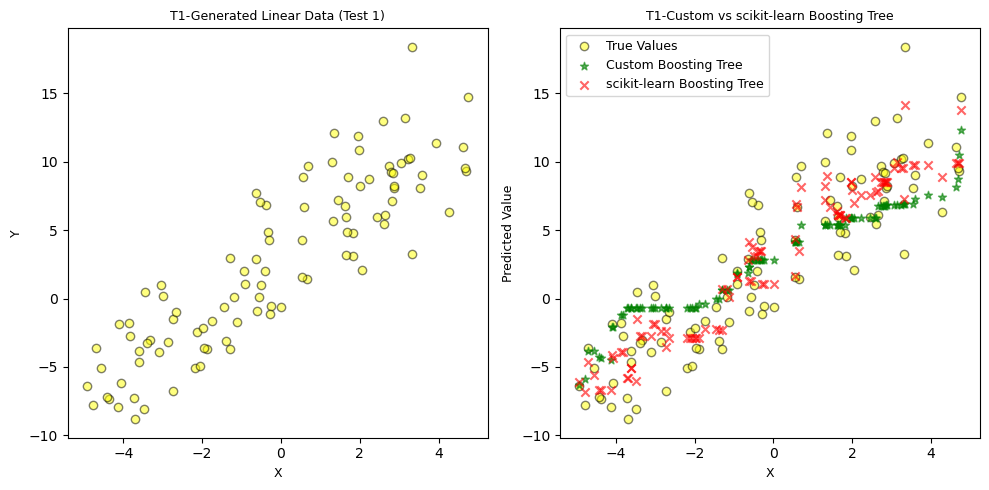

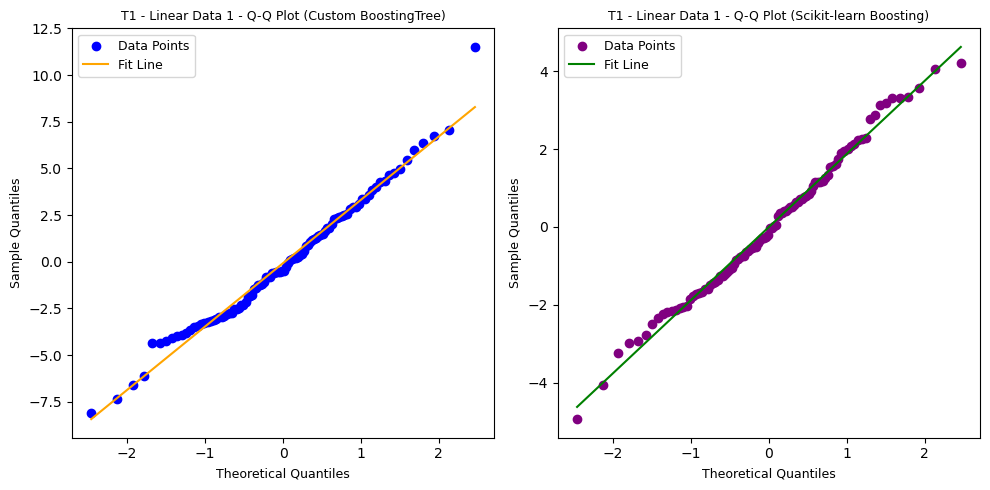

In [207]:
# Test 1 - Linear Data 1 (single feature)
print("Test 1 - Linear Data 1 (single feature)")

# Parameters for the model and data generation
num_trees = 50
learning_rate = 0.1
max_depth = 3
range_ = [-5, 5]
N = 100
seed = 42

# Generate linear data with one feature
X, ys = linear_data_generator1(2, 3, range_, N, seed)

# Check for NaN values in the generated data
print(f"NaN in ys: {np.isnan(ys).any()}")

# Initialize and fit the custom Boosting Tree model
custom_model = BoostingTreeModel(num_trees=num_trees, learning_rate=learning_rate, max_depth=max_depth)
custom_results = custom_model.fit(X, ys)
y_pred_custom = custom_results.predict(X)

# Check for NaN values in predictions
print(f"NaN in y_pred_custom: {np.isnan(y_pred_custom).any()}")

# Replace or filter NaN values (if any)
ys = np.nan_to_num(ys, nan=0.0)
y_pred_custom = np.nan_to_num(y_pred_custom, nan=0.0)

# Initialize and fit the scikit-learn GradientBoostingRegressor for comparison
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error

sklearn_model = GradientBoostingRegressor(
    n_estimators=num_trees, learning_rate=learning_rate, max_depth=max_depth, random_state=seed
)
sklearn_model.fit(X, ys)
y_pred_sklearn = sklearn_model.predict(X)

# Evaluate models using R-squared and MSE
r_squared_custom = MyRSquared.calculate(ys, y_pred_custom)
mse_custom = MyMSE.calculate(ys, y_pred_custom)
r_squared_sklearn = r2_score(ys, y_pred_sklearn)
mse_sklearn = mean_squared_error(ys, y_pred_sklearn)

# Print comparison results
print(f"Custom Boosting Tree - R²: {r_squared_custom:.4f}, MSE: {mse_custom:.4f}")
print(f"scikit-learn Boosting Tree - R²: {r_squared_sklearn:.4f}, MSE: {mse_sklearn:.4f}")

# Plot comparison
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Left plot: Generated data
axs[0].scatter(X, ys, color='yellow', alpha=0.5, edgecolor='k')
axs[0].set_title('T1-Generated Linear Data (Test 1)', fontdict=title_font_main)
axs[0].set_xlabel('X', fontdict=label_font_main)
axs[0].set_ylabel('Y', fontdict=label_font_main)

# Right plot: Predictions comparison
axs[1].scatter(X, ys, label='True Values', color='yellow', alpha=0.5, edgecolor='k')
axs[1].scatter(X, y_pred_custom, label='Custom Boosting Tree', color='green', marker='*', alpha=0.6)
axs[1].scatter(X, y_pred_sklearn, label='scikit-learn Boosting Tree', color='red', marker='x', alpha=0.6)
axs[1].set_title('T1-Custom vs scikit-learn Boosting Tree', fontdict=title_font_main)
axs[1].set_xlabel('X', fontdict=label_font_main)
axs[1].set_ylabel('Predicted Value', fontdict=label_font_main)
axs[1].legend(prop=legend_font_main)

# Display the plots
plt.tight_layout()
plt.show()

# Plot Q-Q plot for residuals
plot_qq(ys, y_pred_custom, y_pred_sklearn, "T1 - Linear Data 1")

For Test Case 1, the scikit-learn GradientBoostingRegressor outperformed the Custom Boosting Tree Model in terms of both R-squared and MSE. The custom model is functional but requires further optimization in tree fitting or ensemble building to compete with scikit-learn's established algorithm.

Test 2 - Linear Data 2 (two features)
Custom Boosting Tree - R²: 0.0946, MSE: 2275.7073, Time: 0.1343s
scikit-learn Boosting Tree - R²: 0.6631, MSE: 846.7990, Time: 0.0058s


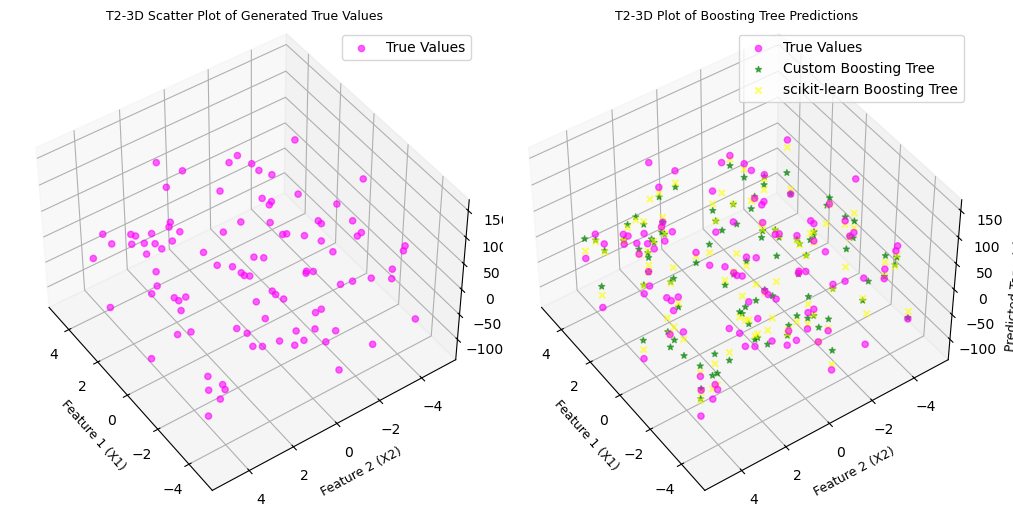

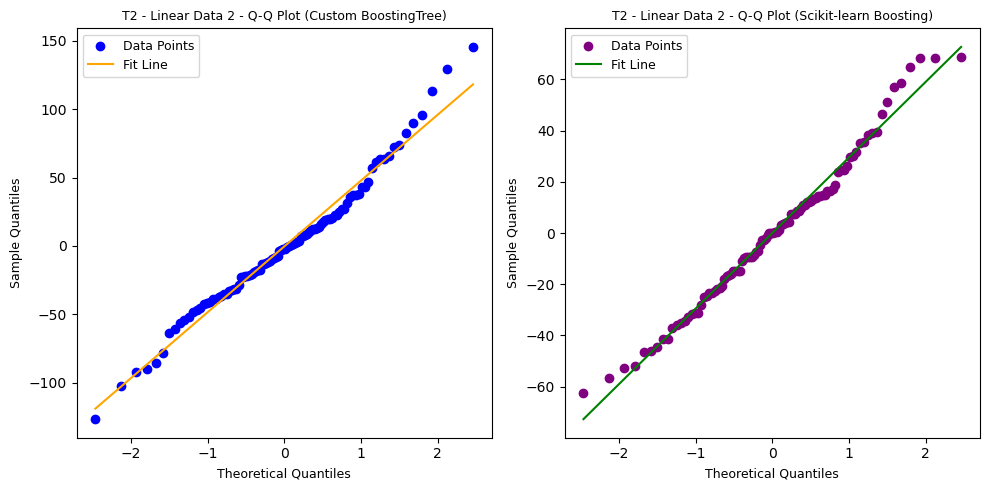

In [208]:
# Test 2 - Linear Data with 2 Features Generator
print("Test 2 - Linear Data 2 (two features)")
# Generate data with 2 features
m = np.array([1.5, -2.0])
b = 5
range_ = [-5, 5]
N = 100
seed = 42
X, ys = linear_data_generator2(m, b, range_, N, seed)

# Parameters for the model
num_trees = 50
learning_rate = 0.10
max_depth = 3

# Initialize and fit the custom Boosting Tree model
custom_model = BoostingTreeModel(num_trees=num_trees, learning_rate=learning_rate, max_depth=max_depth)
start_time = time()
custom_results = custom_model.fit(X, ys)
y_pred_custom = custom_results.predict(X)
custom_time = time() - start_time

# Initialize and fit the scikit-learn GradientBoostingRegressor for comparison
sklearn_model = GradientBoostingRegressor(n_estimators=num_trees, learning_rate=learning_rate, max_depth=max_depth, random_state=42)
start_time = time()
sklearn_model.fit(X, ys)
y_pred_sklearn = sklearn_model.predict(X)
sklearn_time = time() - start_time

# Use R-squared and MSE for evaluation
r_squared_custom = r2_score(ys, y_pred_custom)
mse_custom = mean_squared_error(ys, y_pred_custom)
r_squared_sklearn = r2_score(ys, y_pred_sklearn)
mse_sklearn = mean_squared_error(ys, y_pred_sklearn)

# Print comparison results
print(f"Custom Boosting Tree - R²: {r_squared_custom:.4f}, MSE: {mse_custom:.4f}, Time: {custom_time:.4f}s")
print(f"scikit-learn Boosting Tree - R²: {r_squared_sklearn:.4f}, MSE: {mse_sklearn:.4f}, Time: {sklearn_time:.4f}s")

# Plot comparison in 3D
def plot_boosting_comparison(X, ys, y_pred_custom, y_pred_sklearn):
    fig = plt.figure(figsize=(10, 5))
    ax1 = fig.add_subplot(121, projection='3d')
    ax1.scatter(X[:, 0], X[:, 1], ys, color='magenta', label='True Values', alpha=0.6)
    ax1.set_title('T2-3D Scatter Plot of Generated True Values',fontdict=title_font_main)
    ax1.set_xlabel('Feature 1 (X1)',fontdict=label_font_main)
    ax1.set_ylabel('Feature 2 (X2)',fontdict=label_font_main)
    ax1.set_zlabel('Target (Y)',fontdict=label_font_main)
    ax1.legend()

    # Rotate the first plot with customizable view angles
    ax1.view_init(elev=45, azim=145)

    # Plot 2: 3D plot comparing scikit-learn and Custom Boosting Trees
    ax2 = fig.add_subplot(122, projection='3d')
    ax2.scatter(X[:, 0], X[:, 1], ys, color='magenta', label='True Values', alpha=0.6)
    ax2.scatter(X[:, 0], X[:, 1], y_pred_custom, color='green', marker='*', label='Custom Boosting Tree', alpha=0.6)
    ax2.scatter(X[:, 0], X[:, 1], y_pred_sklearn, color='yellow', marker='x', label='scikit-learn Boosting Tree', alpha=0.6)

    # Rotate the first plot with customizable view angles
    ax2.view_init(elev=45, azim=145)

    # Labels and legend
    ax2.set_title('T2-3D Plot of Boosting Tree Predictions',fontdict=title_font_main)
    ax2.set_xlabel('Feature 1 (X1)',fontdict=label_font_main)
    ax2.set_ylabel('Feature 2 (X2)',fontdict=label_font_main)
    ax2.set_zlabel('Predicted Target (Y)',fontdict=label_font_main)
    ax2.legend()

    plt.tight_layout()
    plt.show()

# Call the plotting function
plot_boosting_comparison(X, ys, y_pred_custom, y_pred_sklearn)


# Plot Q-Q plot for Test 2
plot_qq(ys, y_pred_custom, y_pred_sklearn, "T2 - Linear Data 2")

For Test Case 2, the scikit-learn GradientBoostingRegressor significantly outperformed the Custom Boosting Tree Model in terms of R2 and MSE. The custom model's longer computation time suggests potential inefficiencies, indicating the need for optimization in both its algorithmic design and performance.

Test 3 - Nonlinear Data Generator 1
Custom Boosting Tree - R²: 0.9476, MSE: 0.3323, Time: 0.0850s
scikit-learn Boosting Tree - R²: 0.9859, MSE: 0.0895, Time: 0.0055s


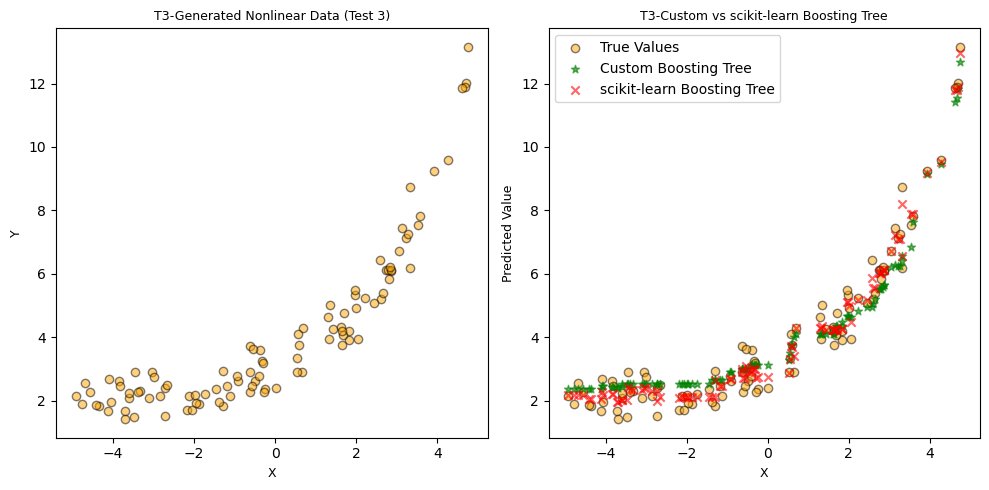

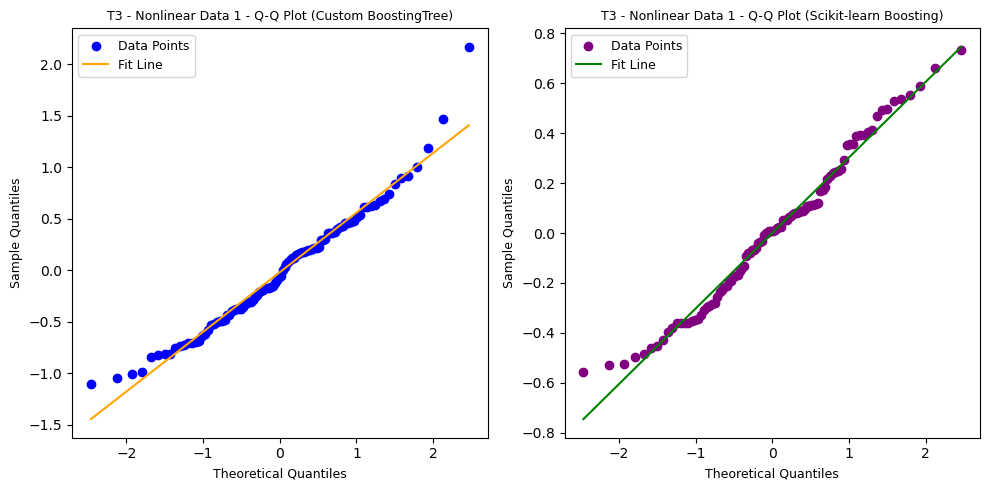

In [209]:
# Test 3 - Nonlinear Data Generator
print("Test 3 - Nonlinear Data Generator 1")

# Parameters for the model and data generation
m = 0.5
b = 2
range_ = [-5, 5]
N = 100
seed = 42

# Generate nonlinear data
X, ys = nonlinear_data_generator1(m, b, range_, N, seed)

# Ensure X is 2D by reshaping
X = X.reshape(-1, 1)

# Model parameters
num_trees = 50
learning_rate = 0.1
max_depth = 3

# Initialize and fit the custom Boosting Tree model
custom_model = BoostingTreeModel(num_trees=num_trees, learning_rate=learning_rate, max_depth=max_depth)
start_time = time()
custom_results = custom_model.fit(X, ys)
y_pred_custom = custom_results.predict(X)
custom_time = time() - start_time

# Initialize and fit the scikit-learn GradientBoostingRegressor for comparison
sklearn_model = GradientBoostingRegressor(n_estimators=num_trees, learning_rate=learning_rate, max_depth=max_depth, random_state=42)
start_time = time()
sklearn_model.fit(X, ys)
y_pred_sklearn = sklearn_model.predict(X)
sklearn_time = time() - start_time

# Use R-squared and MSE for evaluation
r_squared_custom = r2_score(ys, y_pred_custom)
mse_custom = mean_squared_error(ys, y_pred_custom)
r_squared_sklearn = r2_score(ys, y_pred_sklearn)
mse_sklearn = mean_squared_error(ys, y_pred_sklearn)

# Print comparison results
print(f"Custom Boosting Tree - R²: {r_squared_custom:.4f}, MSE: {mse_custom:.4f}, Time: {custom_time:.4f}s")
print(f"scikit-learn Boosting Tree - R²: {r_squared_sklearn:.4f}, MSE: {mse_sklearn:.4f}, Time: {sklearn_time:.4f}s")

# Plot comparison
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Left plot: Plot the entire generated data
axs[0].scatter(X, ys, color='orange', alpha=0.5, edgecolor='k')
axs[0].set_title('T3-Generated Nonlinear Data (Test 3)',fontdict=title_font_main)
axs[0].set_xlabel('X',fontdict=label_font_main)
axs[0].set_ylabel('Y',fontdict=label_font_main)

# Right plot: Comparison of Custom and scikit-learn Boosting Tree predictions
axs[1].scatter(X, ys, label='True Values', color='orange', alpha=0.5, edgecolor='k')
axs[1].scatter(X, y_pred_custom, label='Custom Boosting Tree', color='green', marker='*', alpha=0.6)
axs[1].scatter(X, y_pred_sklearn, label='scikit-learn Boosting Tree', color='red', marker='x', alpha=0.6)
axs[1].set_title('T3-Custom vs scikit-learn Boosting Tree',fontdict=title_font_main)
axs[1].set_xlabel('X',fontdict=label_font_main)
axs[1].set_ylabel('Predicted Value',fontdict=label_font_main)
axs[1].legend()

# Display the plots
plt.tight_layout()
plt.show()

# Plot Q-Q plot for Test 3
plot_qq(ys, y_pred_custom, y_pred_sklearn, "T3 - Nonlinear Data 1")

For Test Case 3, both the Custom Boosting Tree Model and the scikit-learn GradientBoostingRegressor performed well, indicating their effectiveness in handling nonlineardata. These results suggest the custom model is robust for nonlinear patterns but could benefit from further optimization for accuracy and computational performance.

Test 4 - Collinear Data Generator
Custom Boosting Tree - R²: 0.9576, MSE: 15.7822, Time: 0.3815s
scikit-learn Boosting Tree - R²: 0.9989, MSE: 0.4168, Time: 0.0078s


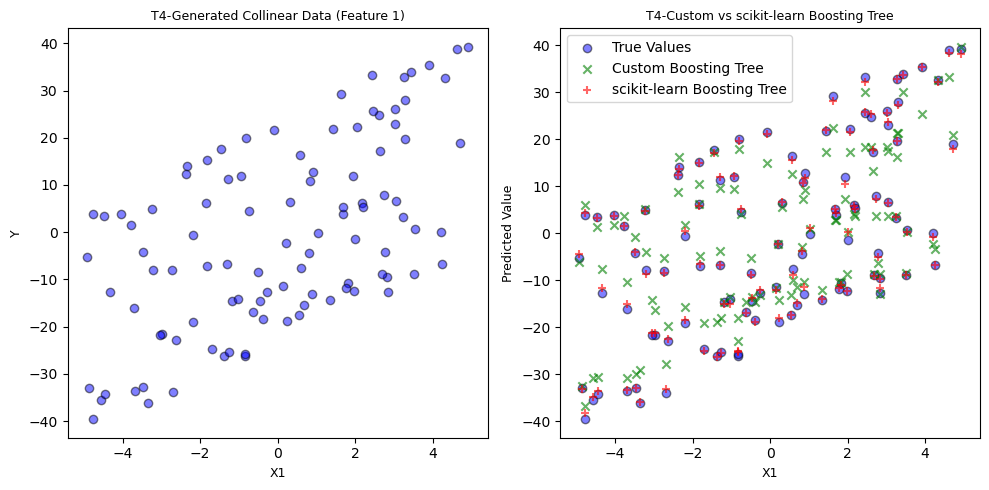

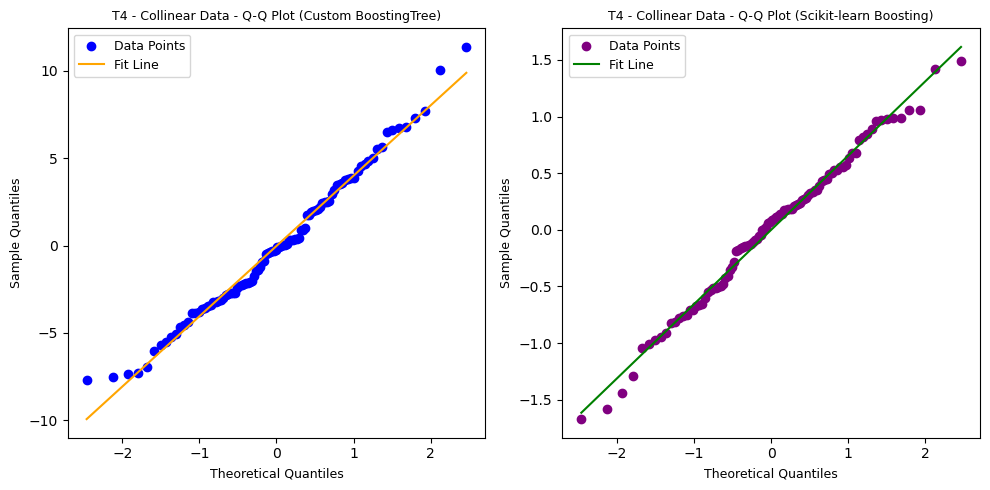

In [210]:
# Test 4 - Collinear Data Generator
print("Test 4 - Collinear Data Generator")

# Parameters for the model and data generation
range_ = [-5, 5]
noise_scale = 0.01
size = (100, 3)  # 100 samples, 3 features to introduce collinearity
seed = 42

# Generate collinear data
X, ys = generate_collinear_data(range_, noise_scale, size, seed)

# Model parameters
num_trees = 50
learning_rate = 0.1
max_depth = 3

# Initialize and fit the custom Boosting Tree model
custom_model = BoostingTreeModel(num_trees=num_trees, learning_rate=learning_rate, max_depth=max_depth)
start_time = time()
custom_results = custom_model.fit(X, ys.flatten())
y_pred_custom = custom_results.predict(X)
custom_time = time() - start_time

# Initialize and fit the scikit-learn GradientBoostingRegressor for comparison
sklearn_model = GradientBoostingRegressor(n_estimators=num_trees, learning_rate=learning_rate, max_depth=max_depth, random_state=42)
start_time = time()
sklearn_model.fit(X, ys.flatten())
y_pred_sklearn = sklearn_model.predict(X)
sklearn_time = time() - start_time

# Use R-squared and MSE for evaluation
r_squared_custom = r2_score(ys, y_pred_custom)
mse_custom = mean_squared_error(ys, y_pred_custom)
r_squared_sklearn = r2_score(ys, y_pred_sklearn)
mse_sklearn = mean_squared_error(ys, y_pred_sklearn)


print(f"Custom Boosting Tree - R²: {r_squared_custom:.4f}, MSE: {mse_custom:.4f}, Time: {custom_time:.4f}s")
print(f"scikit-learn Boosting Tree - R²: {r_squared_sklearn:.4f}, MSE: {mse_sklearn:.4f}, Time: {sklearn_time:.4f}s")

# Plot comparison
fig, axs = plt.subplots(1, 2, figsize=(10, 5))


# Left plot: Plot the entire generated data
axs[0].scatter(X[:, 0], ys, color='blue', alpha=0.5, edgecolor='k')
axs[0].set_title('T4-Generated Collinear Data (Feature 1)',fontdict=title_font_main)
axs[0].set_xlabel('X1',fontdict=label_font_main)
axs[0].set_ylabel('Y',fontdict=label_font_main)

# Right plot: Comparison of Custom and scikit-learn Boosting Tree predictions
axs[1].scatter(X[:, 0], ys, label='True Values', color='blue', alpha=0.5, edgecolor='k')
axs[1].scatter(X[:, 0], y_pred_custom, label='Custom Boosting Tree', color='green', marker='x', alpha=0.6)
axs[1].scatter(X[:, 0], y_pred_sklearn, label='scikit-learn Boosting Tree', color='red', marker='+', alpha=0.6)
axs[1].set_title('T4-Custom vs scikit-learn Boosting Tree',fontdict=title_font_main)
axs[1].set_xlabel('X1',fontdict=label_font_main)
axs[1].set_ylabel('Predicted Value',fontdict=label_font_main)
axs[1].legend()

# Display the plots
plt.tight_layout()
plt.show()

# Plot Q-Q plot for Test 4
plot_qq(ys.flatten(), y_pred_custom, y_pred_sklearn, "T4 - Collinear Data")

For Test Case 4, the scikit-learn GradientBoostingRegressor outperformed the Custom Boosting Tree Model. Despite the strong performance of the custom model, the scikit-learn model's superior precision and significantly faster runtime highlight its optimization and robustness, particularly in handling collinear data. 

Test 5 - Periodic Data Generator
Custom Boosting Tree - R²: 0.3161, MSE: 22.6973, Time: 0.0704s
scikit-learn Boosting Tree - R²: 0.9932, MSE: 0.2269, Time: 0.0062s


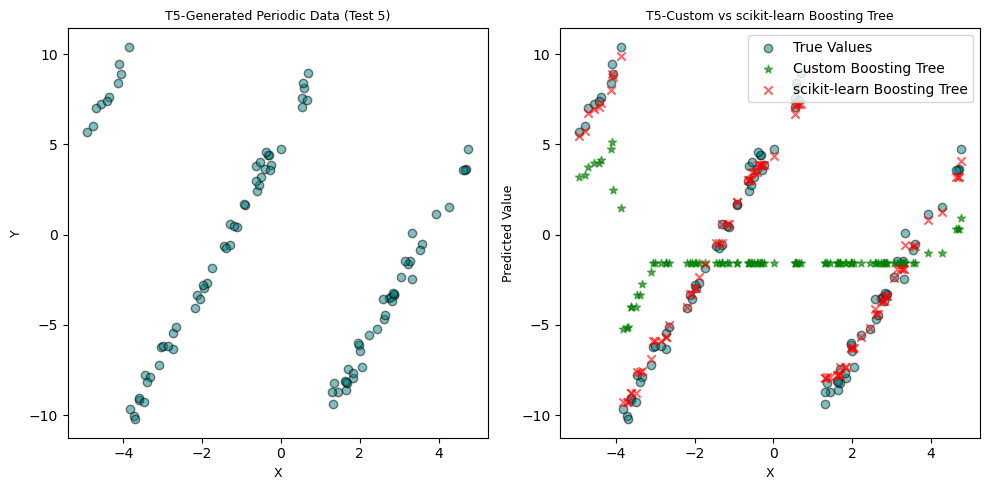

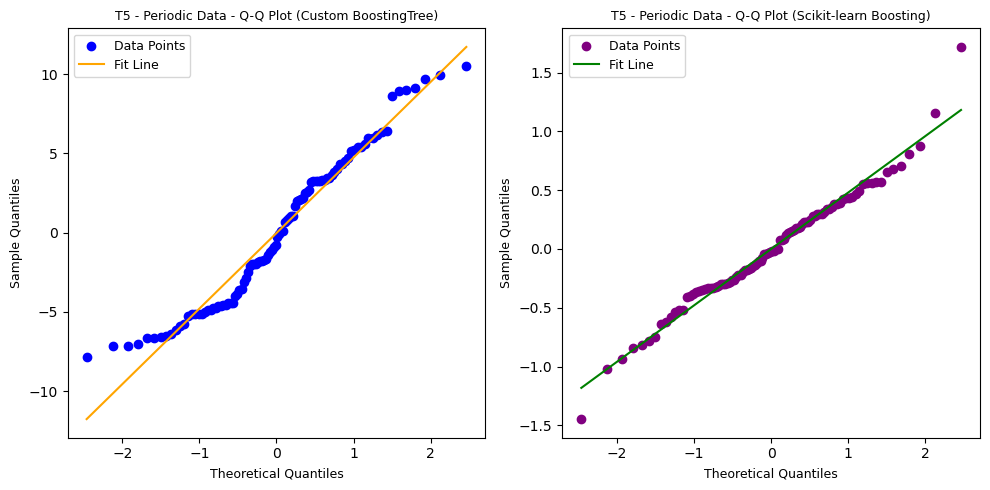

In [211]:
# Test 5 - Periodic Data Generator
print("Test 5 - Periodic Data Generator")

# Parameters for the model and data generation
period = 5
amplitude = 10
range_ = [-5, 5]
noise_scale = 0.5
size = 100
seed = 42

# Generate periodic data
X, ys = generate_periodic_data(period, amplitude, range_, noise_scale, size, seed)

# Reshape the data to fit into models
X = X.reshape(-1, 1)

# Model parameters
num_trees = 50
learning_rate = 0.1
max_depth = 3

# Initialize and fit the custom Boosting Tree model
custom_model = BoostingTreeModel(num_trees=num_trees, learning_rate=learning_rate, max_depth=max_depth)
start_time = time()
custom_results = custom_model.fit(X, ys)
y_pred_custom = custom_results.predict(X)
custom_time = time() - start_time

# Initialize and fit the scikit-learn GradientBoostingRegressor for comparison
sklearn_model = GradientBoostingRegressor(n_estimators=num_trees, learning_rate=learning_rate, max_depth=max_depth, random_state=42)
start_time = time()
sklearn_model.fit(X, ys)
y_pred_sklearn = sklearn_model.predict(X)
sklearn_time = time() - start_time

# Use R-squared and MSE for evaluation
r_squared_custom = r2_score(ys, y_pred_custom)
mse_custom = mean_squared_error(ys, y_pred_custom)
r_squared_sklearn = r2_score(ys, y_pred_sklearn)
mse_sklearn = mean_squared_error(ys, y_pred_sklearn)

# Print comparison results
print(f"Custom Boosting Tree - R²: {r_squared_custom:.4f}, MSE: {mse_custom:.4f}, Time: {custom_time:.4f}s")
print(f"scikit-learn Boosting Tree - R²: {r_squared_sklearn:.4f}, MSE: {mse_sklearn:.4f}, Time: {sklearn_time:.4f}s")

# Plot comparison
fig, axs = plt.subplots(1, 2, figsize=(10, 5))


# Left plot: Plot the generated periodic data
axs[0].scatter(X, ys, color='teal', alpha=0.5, edgecolor='k')
axs[0].set_title('T5-Generated Periodic Data (Test 5)',fontdict=title_font_main)
axs[0].set_xlabel('X',fontdict=label_font_main)
axs[0].set_ylabel('Y',fontdict=label_font_main)

# Right plot: Comparison of Custom and scikit-learn Boosting Tree predictions
axs[1].scatter(X, ys, label='True Values', color='teal', alpha=0.5, edgecolor='k')
axs[1].scatter(X, y_pred_custom, label='Custom Boosting Tree', color='green', marker='*', alpha=0.6)
axs[1].scatter(X, y_pred_sklearn, label='scikit-learn Boosting Tree', color='red', marker='x', alpha=0.6)
axs[1].set_title('T5-Custom vs scikit-learn Boosting Tree',fontdict=title_font_main)
axs[1].set_xlabel('X',fontdict=label_font_main)
axs[1].set_ylabel('Predicted Value',fontdict=label_font_main)
axs[1].legend()

# Display the plots
plt.tight_layout()
plt.show()

# Plot Q-Q plot for Test 5
plot_qq(ys, y_pred_custom, y_pred_sklearn, "T5 - Periodic Data")

For Test Case 5, the scikit-learn GradientBoostingRegressor significantly outperformed the Custom Boosting Tree Model when modeling periodic data. The periodic nature of the data posed a significant challenge for the custom model, leading to poor generalization and inaccurate predictions. Additionally, the custom model's runtime was notably longer.These results highlight the need for further enhancements in the custom model's ability to capture complex periodic patterns effectively.

Test 6 - Higher Dimensional Data Generator
Custom Boosting Tree - R²: 0.9952, MSE: 12.8638, Time: 0.3209s
scikit-learn Boosting Tree - R²: 0.9990, MSE: 2.6319, Time: 0.0068s


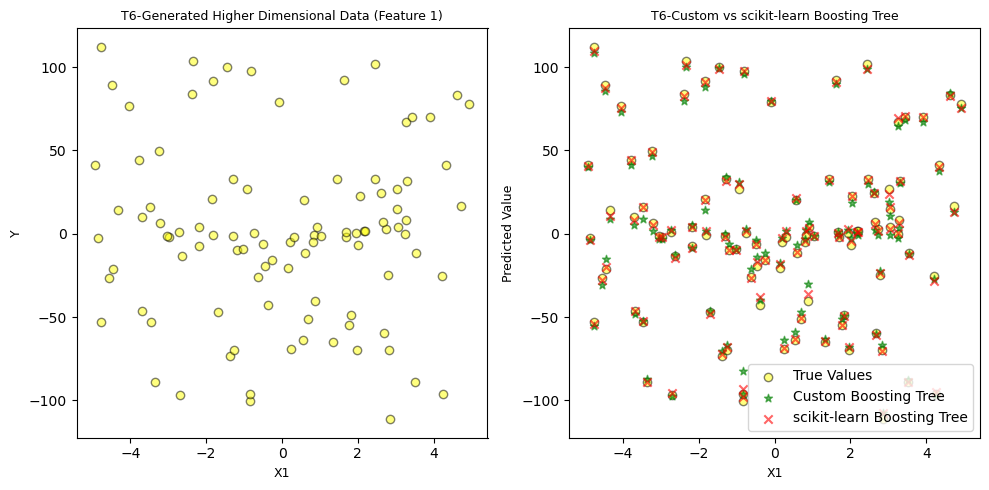

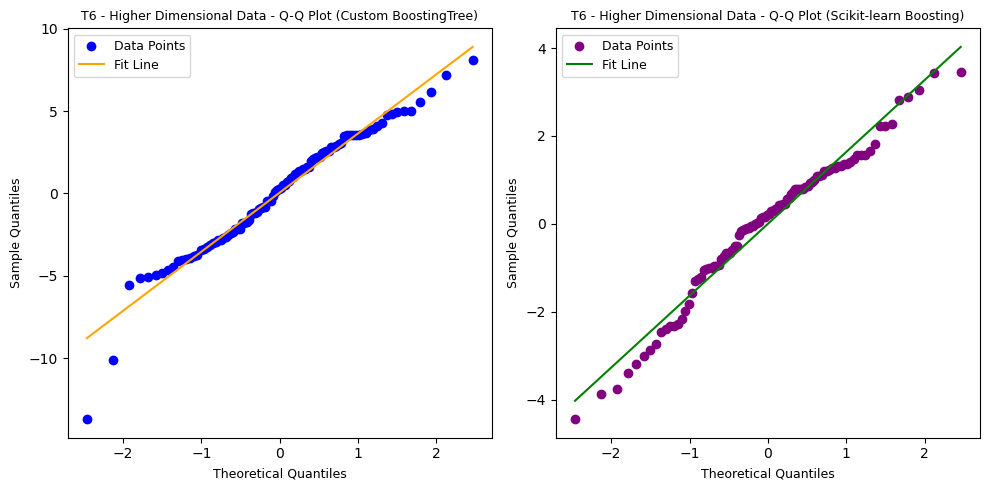

In [212]:
# Test 6 - Higher Dimensional Data Generator
print("Test 6 - Higher Dimensional Data Generator")

# Parameters for the model and data generation
range_ = [-5, 5]
noise_scale = 0.5
size = (100, 3)  # Higher dimensional data with 3 features
seed = 42

# Generate higher-dimensional data
X, ys = generate_higher_dim_data(range_, noise_scale, size, seed)

# Model parameters
num_trees = 50
learning_rate = 0.1
max_depth = 3

# Initialize and fit the custom Boosting Tree model
custom_model = BoostingTreeModel(num_trees=num_trees, learning_rate=learning_rate, max_depth=max_depth)
start_time = time()
custom_results = custom_model.fit(X, ys)
y_pred_custom = custom_results.predict(X)
custom_time = time() - start_time

# Initialize and fit the scikit-learn GradientBoostingRegressor for comparison
sklearn_model = GradientBoostingRegressor(n_estimators=num_trees, learning_rate=learning_rate, max_depth=max_depth, random_state=42)
start_time = time()
sklearn_model.fit(X, ys)
y_pred_sklearn = sklearn_model.predict(X)
sklearn_time = time() - start_time

# Use R-squared and MSE for evaluation
r_squared_custom = r2_score(ys, y_pred_custom)
mse_custom = mean_squared_error(ys, y_pred_custom)
r_squared_sklearn = r2_score(ys, y_pred_sklearn)
mse_sklearn = mean_squared_error(ys, y_pred_sklearn)

# Print comparison results
print(f"Custom Boosting Tree - R²: {r_squared_custom:.4f}, MSE: {mse_custom:.4f}, Time: {custom_time:.4f}s")
print(f"scikit-learn Boosting Tree - R²: {r_squared_sklearn:.4f}, MSE: {mse_sklearn:.4f}, Time: {sklearn_time:.4f}s")

# Plot comparison
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Left plot: Visualize the generated data (plotting only one dimension of X for simplicity)
axs[0].scatter(X[:, 0], ys, color='yellow', alpha=0.5, edgecolor='k')
axs[0].set_title('T6-Generated Higher Dimensional Data (Feature 1)',fontdict=title_font_main)
axs[0].set_xlabel('X1',fontdict=label_font_main)
axs[0].set_ylabel('Y',fontdict=label_font_main)

# Right plot: Comparison of Custom and scikit-learn Boosting Tree predictions
axs[1].scatter(X[:, 0], ys, label='True Values', color='yellow', alpha=0.5, edgecolor='k')
axs[1].scatter(X[:, 0], y_pred_custom, label='Custom Boosting Tree', color='green', marker='*', alpha=0.6)
axs[1].scatter(X[:, 0], y_pred_sklearn, label='scikit-learn Boosting Tree', color='red', marker='x', alpha=0.6)
axs[1].set_title('T6-Custom vs scikit-learn Boosting Tree',fontdict=title_font_main)
axs[1].set_xlabel('X1',fontdict=label_font_main)
axs[1].set_ylabel('Predicted Value',fontdict=label_font_main)
axs[1].legend()

# Display the plots
plt.tight_layout()
plt.show()

# Plot Q-Q plot for Test 6
plot_qq(ys, y_pred_custom, y_pred_sklearn, "T6 - Higher Dimensional Data")

Despite not outperforming the scikit-learn model, the Custom Boosting Tree Model demonstrated a strong fit for the high-dimensional data, yielding better results than in other test cases.

Test 7 - High Collinearity Data Generator with 50 Variables
Custom Boosting Tree - R²: 0.9995, MSE: 224.6327, Time: 5.0352s
scikit-learn Boosting Tree - R²: 1.0000, MSE: 18.4541, Time: 0.0211s


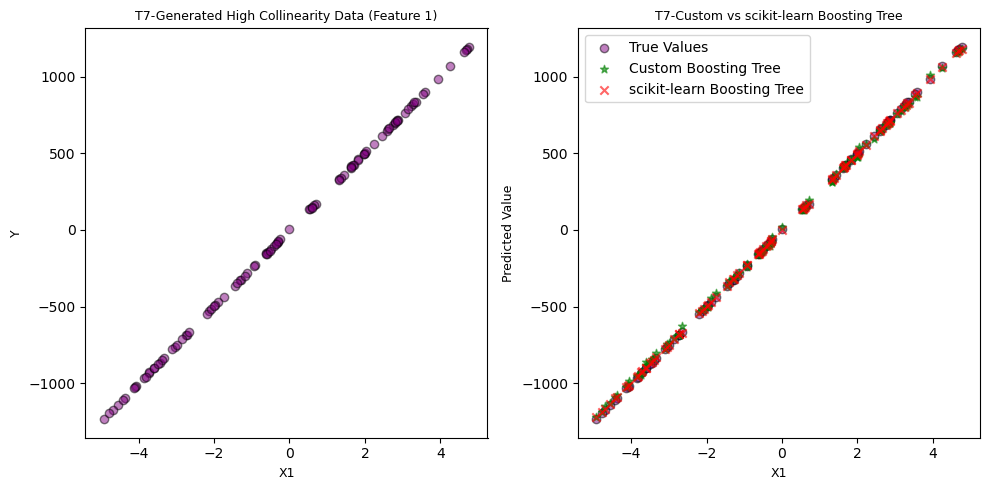

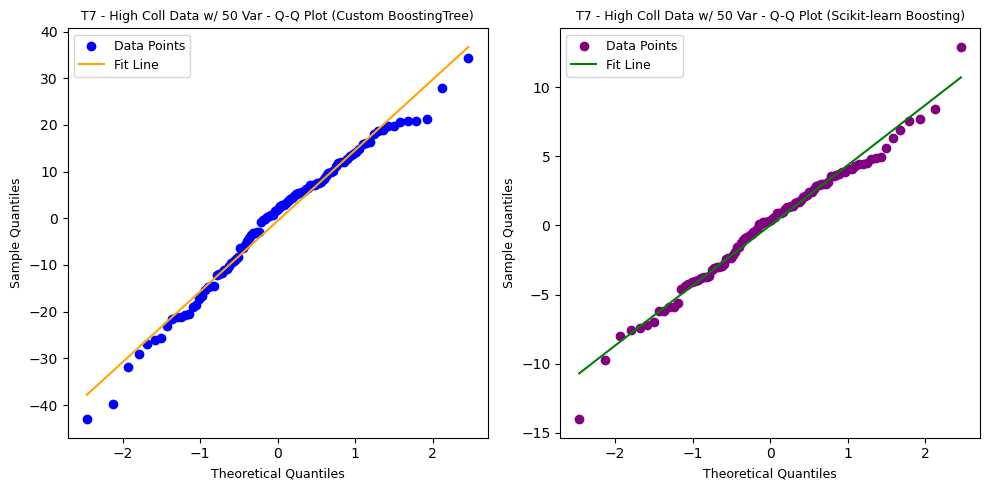

In [213]:
# Test 7 - High Collinearity Data with Multiple Variables
print("Test 7 - High Collinearity Data Generator with 50 Variables")

# Parameters for the model and data generation
n_features = 50  # Number of highly collinear features
N = 100
seed = 42

# Generate highly collinear data
X, ys = generate_high_collinear_data(n_features, N, seed)

# Model parameters
num_trees = 50
learning_rate = 0.1
max_depth = 3

# Initialize and fit the custom Boosting Tree model
custom_model = BoostingTreeModel(num_trees=num_trees, learning_rate=learning_rate, max_depth=max_depth)
start_time = time()
custom_results = custom_model.fit(X, ys)
y_pred_custom = custom_results.predict(X)
custom_time = time() - start_time

# Initialize and fit the scikit-learn GradientBoostingRegressor for comparison
sklearn_model = GradientBoostingRegressor(n_estimators=num_trees, learning_rate=learning_rate, max_depth=max_depth, random_state=42)
start_time = time()
sklearn_model.fit(X, ys)
y_pred_sklearn = sklearn_model.predict(X)
sklearn_time = time() - start_time

# Use R-squared and MSE for evaluation
r_squared_custom = r2_score(ys, y_pred_custom)
mse_custom = mean_squared_error(ys, y_pred_custom)
r_squared_sklearn = r2_score(ys, y_pred_sklearn)
mse_sklearn = mean_squared_error(ys, y_pred_sklearn)

# Print comparison results
print(f"Custom Boosting Tree - R²: {r_squared_custom:.4f}, MSE: {mse_custom:.4f}, Time: {custom_time:.4f}s")
print(f"scikit-learn Boosting Tree - R²: {r_squared_sklearn:.4f}, MSE: {mse_sklearn:.4f}, Time: {sklearn_time:.4f}s")

# Plot comparison
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Left plot: Visualize the generated data for the first feature
axs[0].scatter(X[:, 0], ys, color='purple', alpha=0.5, edgecolor='k')
axs[0].set_title('T7-Generated High Collinearity Data (Feature 1)',fontdict=title_font_main)
axs[0].set_xlabel('X1',fontdict=label_font_main)
axs[0].set_ylabel('Y',fontdict=label_font_main)

# Right plot: Comparison of Custom and scikit-learn Boosting Tree predictions
axs[1].scatter(X[:, 0], ys, label='True Values', color='purple', alpha=0.5, edgecolor='k')
axs[1].scatter(X[:, 0], y_pred_custom, label='Custom Boosting Tree', color='green', marker='*', alpha=0.6)
axs[1].scatter(X[:, 0], y_pred_sklearn, label='scikit-learn Boosting Tree', color='red', marker='x', alpha=0.6)
axs[1].set_title('T7-Custom vs scikit-learn Boosting Tree',fontdict=title_font_main)
axs[1].set_xlabel('X1',fontdict=label_font_main)
axs[1].set_ylabel('Predicted Value',fontdict=label_font_main)
axs[1].legend()

# Display the plots
plt.tight_layout()
plt.show()

# Plot Q-Q plot for Test 7
plot_qq(ys, y_pred_custom, y_pred_sklearn, "T7 - High Coll Data w/ 50 Var")

The scikit-learn Gradient Boosting Regressor slightly outperformed the Custom Boosting Tree. Despite of this the Custom Boosting Tree handled the high collinearity effectively, showcasing strong predictive capability in a challenging high-dimensional setting.

Test 8 - Extreme Scenario Data Generator
Test 8 - Ext. Sce w/ Sparsity, Collinearity, and Noise
Custom Boosting Tree - R²: 0.9676, MSE: 22451.1868, Time: 12.3998s
scikit-learn Boosting Tree - R²: 0.9854, MSE: 10098.8010, Time: 0.0856s


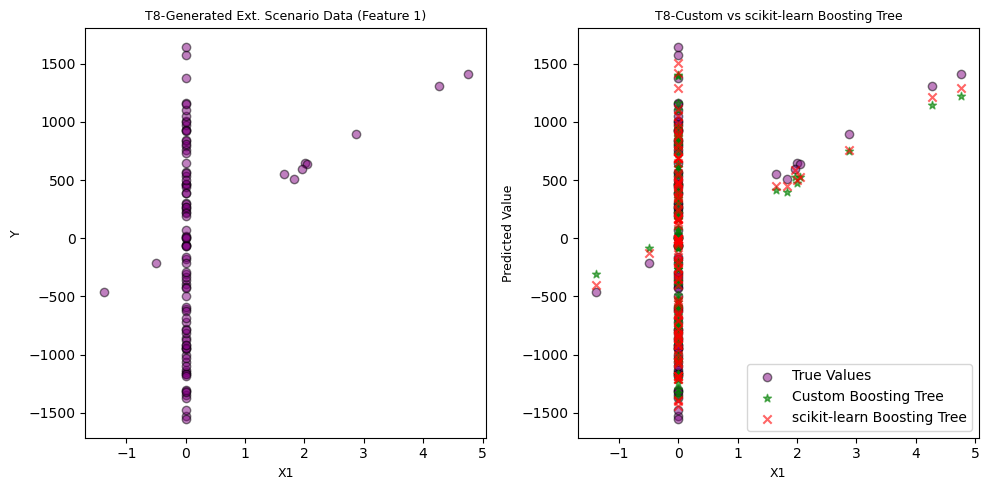

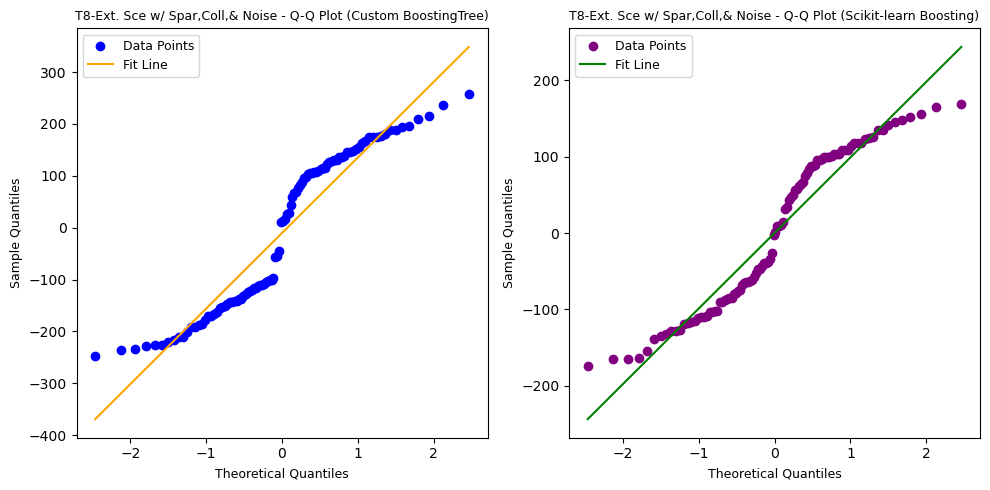

In [214]:
# Test 8 - Extreme Scenario with Sparsity, Collinearity, and Noise
print("Test 8 - Extreme Scenario Data Generator")

# Parameters for the model and data generation
n_features = 1000  # High dimensionality
N = 100  # Fewer observations compared to features
seed = 42

# Generate horrible data
X, ys = generate_horrible_data(n_features, N, seed)

# Model parameters
num_trees = 50
learning_rate = 0.1
max_depth = 3

# Initialize and fit the custom Boosting Tree model
custom_model = BoostingTreeModel(num_trees=num_trees, learning_rate=learning_rate, max_depth=max_depth)
start_time = time()
custom_results = custom_model.fit(X, ys)
y_pred_custom = custom_results.predict(X)
custom_time = time() - start_time

# Initialize and fit the scikit-learn GradientBoostingRegressor for comparison
sklearn_model = GradientBoostingRegressor(n_estimators=num_trees, learning_rate=learning_rate, max_depth=max_depth, random_state=42)
start_time = time()
sklearn_model.fit(X, ys)
y_pred_sklearn = sklearn_model.predict(X)
sklearn_time = time() - start_time

# Use R-squared and MSE for evaluation
r_squared_custom = r2_score(ys, y_pred_custom)
mse_custom = mean_squared_error(ys, y_pred_custom)
r_squared_sklearn = r2_score(ys, y_pred_sklearn)
mse_sklearn = mean_squared_error(ys, y_pred_sklearn)

# Print comparison results
print("Test 8 - Ext. Sce w/ Sparsity, Collinearity, and Noise")
print(f"Custom Boosting Tree - R²: {r_squared_custom:.4f}, MSE: {mse_custom:.4f}, Time: {custom_time:.4f}s")
print(f"scikit-learn Boosting Tree - R²: {r_squared_sklearn:.4f}, MSE: {mse_sklearn:.4f}, Time: {sklearn_time:.4f}s")


# Plot comparison
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Left plot: Visualize the generated data for the first feature
axs[0].scatter(X[:, 0], ys, color='purple', alpha=0.5, edgecolor='k')
axs[0].set_title('T8-Generated Ext. Scenario Data (Feature 1)',fontdict=title_font_main)
axs[0].set_xlabel('X1',fontdict=label_font_main)
axs[0].set_ylabel('Y',fontdict=label_font_main)

# Right plot: Comparison of Custom and scikit-learn Boosting Tree predictions
axs[1].scatter(X[:, 0], ys, label='True Values', color='purple', alpha=0.5, edgecolor='k')
axs[1].scatter(X[:, 0], y_pred_custom, label='Custom Boosting Tree', color='green', marker='*', alpha=0.6)
axs[1].scatter(X[:, 0], y_pred_sklearn, label='scikit-learn Boosting Tree', color='red', marker='x', alpha=0.6)
axs[1].set_title('T8-Custom vs scikit-learn Boosting Tree',fontdict=title_font_main)
axs[1].set_xlabel('X1',fontdict=label_font_main)
axs[1].set_ylabel('Predicted Value',fontdict=label_font_main)
axs[1].legend()

# Display the plots
plt.tight_layout()
plt.show()

# Plot Q-Q plot for Test 8
plot_qq(ys, y_pred_custom, y_pred_sklearn, "T8-Ext. Sce w/ Spar,Coll,& Noise")

In this challenging scenario, the scikit-learn model significantly outperformed the custom model in terms of MSE, achieving a much lower error and marginally better R² score. The runtime comparison highlights a substantial gap, with the custom model being slower. Despite the noise and complexity, the custom model was able to achieve reasonable accuracy but demonstrated limitations in handling extreme scenarios efficiently.